# PROJET 5 - SEGMENTATION DE CLIENTS D'UN SITE DE E-COMMERCE
## MAINTENANCE
***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats as st
import re
from matplotlib.patches import Patch

from sklearn.metrics import silhouette_score

In [3]:
from sklearn import metrics

In [2]:
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', size = 16)

In [56]:
#On importe le data avec les commandes en id, non groupées par client.

data_bis = pd.read_csv('data/data_clients_no_rfm', sep = ',')

In [58]:
data_bis.shape

(112650, 6)

In [60]:
#On passe la date en timestamp

data_bis['date'] = pd.to_datetime(data_bis['date'])
data_bis['timestamp'] = data_bis['date'].apply(lambda x : datetime.timestamp(x)).astype(int)

#Enfin, on change cela en jour en prenant la date la plus récente en référence
data_bis['recence'] = round((data_bis['timestamp'].max() - data_bis['timestamp']) / (24*3600), 2)

In [62]:
#On ne garde que les features qui nous importent

data_bis = data_bis[['id', 'montant', 'recence']]


#On cree la feature durée utilisée dans notre fonction ci-dessous

data_bis['duree'] = data_bis['recence'].max() - data_bis['recence']


data_bis.head()

,id,montant,recence,duree
0,7c396fd4830fd04220f754e42b4e5bff,38.71,335.92,392.57
1,af07308b275d755c9edb36a90c618231,141.46,40.52,687.97
2,3a653a41f6f9fc3d2a113cf8398680e8,179.12,26.02,702.47
3,7c142cf63193a1473d2e66489a9ae977,72.20,288.53,439.96
4,72632f0f9dd73dfee390c9b22eb56dd6,28.62,201.45,527.04


In [64]:
from sklearn.metrics import adjusted_rand_score

In [66]:
#On initialise notre Kmeans
def evolution(time_initial, pas_weeks, n_clusters, nb_iterations, save):

    """
    Trace l'évolution de l'ARI (Adjusted Rand Index) sur des données en fonction du temps.

    Cette fonction utilise le clustering KMeans pour calculer et tracer l'ARI
    entre des clusters initiaux et l'évolution des clusters à travers le temps.
    
    Paramètres :
    ------------
    time_initial : int
        La durée initiale en jours pour le filtrage des données.
    pas_weeks : int
        Le nombre de semaines par incrément pour la progression du temps.
    n_clusters : int
        Le nombre de clusters à utiliser pour KMeans.
    nb_iterations : int
        Le nombre maximum d'itérations à afficher.
    save : str
        Si 'yes', la figure sera sauvegardée en format PDF, sinon, elle sera seulement affichée.

    Returns :
    ---------
    None
        La fonction ne renvoie rien mais affiche ou enregistre un graphique de l'évolution de l'ARI.
    """
    
    #On pose nos listes (pour les plots) et variables
    ari_scores_evo = []
    time = time_initial
    nb_semaines = 0
    nb_semaines_list = []
    
    #Nos données initiales
    data_initial = data_bis.loc[data_bis['duree'] < time, :]
    data_initial = data_initial[['id', 'montant', 'recence', 'duree']].groupby('id').agg({'montant': 'sum', 'recence': 'max', 'id' : 'count', 'duree' : 'max'}).rename(columns={'id': 'nb_achats'}).reset_index()
    
    X_initial = data_initial[features].values
    
    #On initialise notre kmeans
    scaler_initial = StandardScaler()
    X_initial_scaled = scaler_initial.fit_transform(X_initial)
    
    kmeans_initial = KMeans(n_clusters = n_clusters, n_init = 10)
    kmeans_initial.fit(X_initial_scaled)
    
    while time < data_bis['duree'].max():
        #scaler_evolution = StandardScaler()    
        data_evo = data_bis.loc[data_bis['duree'] < time, :]
        data_evo = data_evo[['id', 'montant', 'recence', 'duree']].groupby('id').agg({'montant': 'sum', 'recence': 'max', 'id' : 'count', 'duree' : 'max'}).rename(columns={'id': 'nb_achats'}).reset_index()
        X = data_evo[features].values
        X_scaled = scaler_initial.transform(X)
        labels_initial = kmeans_initial.predict(X_scaled)
        nb_semaines_list.append(nb_semaines)
        
        kmeans_evo = KMeans(n_clusters = n_clusters, n_init = 10) 
        kmeans_evo.fit(X_scaled)
        labels_evolution = kmeans_evo.fit_predict(X_scaled)
        
        ari_score = adjusted_rand_score(labels_initial, labels_evolution)
        ari_scores_evo.append(ari_score)
        
        time = time + 7*pas_weeks
        nb_semaines += pas_weeks
        
    if nb_iterations > len(nb_semaines_list):
        nb_iterations = len(nb_semaines_list)
    elif nb_iterations < 0:
        nb_iterations = 0
    
    if save == 'yes':
        plt.figure(figsize=(12,6))
        sns.lineplot(x = nb_semaines_list[:nb_iterations], y = ari_scores_evo[:nb_iterations], marker = 'o', color = 'blue')
        plt.xlabel("Nombre de semaines")
        plt.ylabel("ARI Score")
        plt.title("\\textbf{{ARI Score}}", pad = 20)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.axhline(y=0.8, color='red', linestyle='--', label='y = 0.8')
        plt.savefig(f"ari_score_{time_initial}_{pas_weeks}.pdf", bbox_inches = 'tight')
        plt.show()
    else:
        plt.figure(figsize=(12,6))
        sns.lineplot(x = nb_semaines_list[:nb_iterations], y = ari_scores_evo[:nb_iterations], marker = 'o', color = 'blue')
        plt.xlabel("Nombre de semaines")
        plt.ylabel("ARI Score")
        plt.title("\\textbf{{ARI Score}}", pad = 20)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.axhline(y=0.8, color='red', linestyle='--', label='y = 0.8')
        #plt.savefig(f"ari_score_{time_initial}_{pas_weeks}.pdf", bbox_inches = 'tight')
        plt.show()

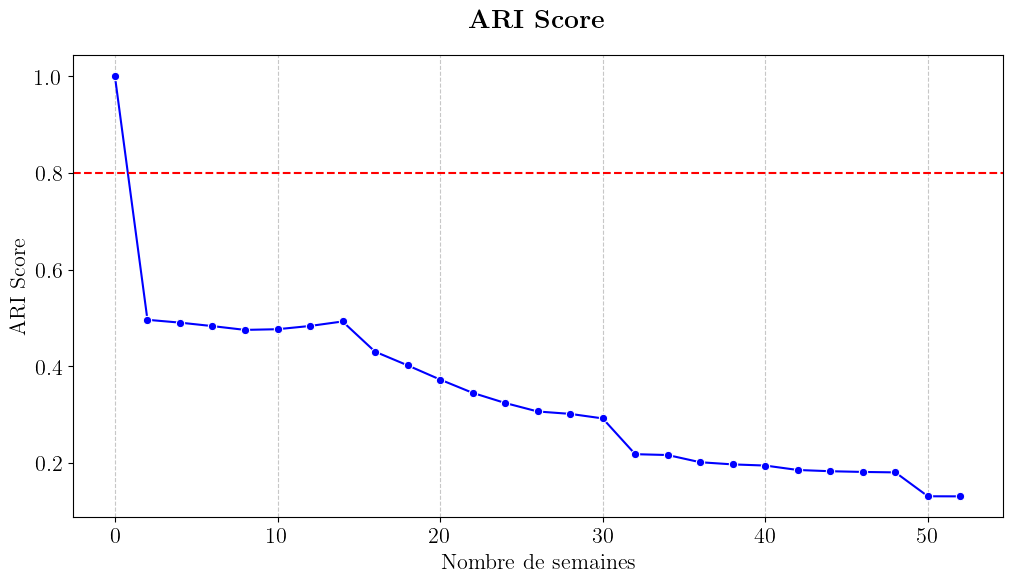

In [68]:
#On fait tourner la fonction avec un pas de 2 semaines.

evolution(360, 2, 6, 80, 'yes')

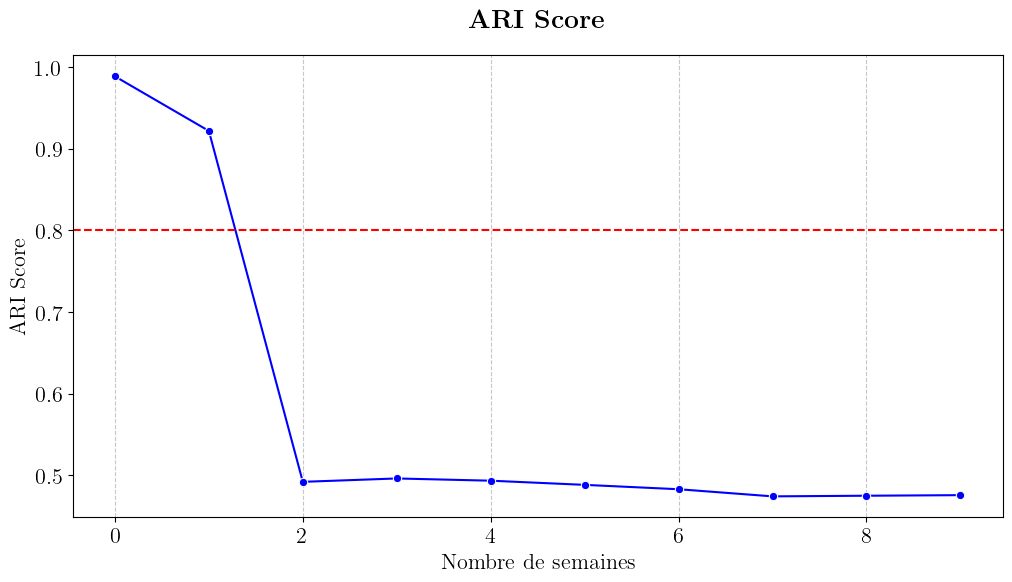

In [70]:
#On fait tourner avec un pas de 1 semaine

evolution(360, 1, 6, 10, 'yes')